# Coding project - Picture enhancement

Write code that automatically enhances a photograph.

<img src="./etretat.jpg" width="250px" />
<img src="./ex_enhance.jpg" width="250px" />

"Enhance" may mean a lot of different things, and we encourage you to be creative in which enhancements you want to implement.

Some possibilities include (not an exhaustive list):

* Noise reduction
* Auto-level
* Gamma correction (with gamma provided by the user or automatically determined from the image histogram)
* Increase colour saturation
* ...

# REPORT
In order to enhance (in a goal of aisthetics) automatically a photograph, multiple functions are defined. The different explanations for every function and process will be featured below. Note that this notebook can be seen as a photoshop tool where the user can choose the method he wishes to use on the input image.

In [454]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.io import imread,imshow,imsave

## Median filter
First, the input image will be denoise through the medianrgb() function, it uses a median filter from the skimage.filters.rank library and it is applied on the three channels rgb of the input. The user can choose either the input image and the radius for the median filter.

In [453]:
from skimage.filters.rank import median
from skimage.morphology import disk

def medianrgb(im, radius) :
    output = np.zeros(im.shape)
    outputr = median(im[:,:,0], disk(radius))
    outputg = median(im[:,:,1], disk(radius))
    outputb = median(im[:,:,2], disk(radius))
    output[:,:,0] = outputr
    output[:,:,1] = outputg
    output[:,:,2] = outputb
    return output.astype('uint8')

## Auto-level

This auto-level function aims to "stretch" the histogram of the input image, it allows to better use the dynamic range.
Two ways are proposed to determine the two threshold variables (Tmin and Tmax) :
* by checking the image histogram
* by choosing a percentage of pixels

The input image is converted in hsv to compute its normalized cumulative histogram easier.
By default, Tmin and Tmax will be a percentage of pixels fixed at 2% and 98% respectively. The user can change the percentage if he wishes. In addition, he can also choose a direct value by modifying the parameter mode to 'yes' and by changing the parameters TminChosen and TmaxChosen. 


In [455]:
from skimage.color import rgb2hsv, hsv2rgb
def cumul_hist(image) :         # Normalized cumulative histogram
    cumul_h = np.zeros((256,))
    c = 0
    for v in range(256) :
        c += (image == v).sum()
        cumul_h[v] = c
    cumul_h /= cumul_h.max()
    return cumul_h


def autolevel(image, mode = 'no', TminChosen = 0.02, TmaxChosen = 0.98) :
    im = rgb2hsv(image)     # Convert from rgb to hsv
    lut = np.arange(256)    # Look-up-table
    
    if (mode == 'no' and TminChosen >= 0. and TmaxChosen <= 1.) :
        h = cumul_hist(im2[:,:,2]*255)   # Multiply the values by 255 to transform to build the histogram
        for v in range(256):
            if h[v] > TminChosen : break
        Tmin = v - 1
        for v in range(256):
            if h[255-v] < TmaxChosen : break
        Tmax = (255-v) + 1
        
    elif (mode == 'yes' and TminChosen >= 0 and TmaxChosen <= 255) :
        Tmin = TminChosen
        Tmax = TmaxChosen
    
    else :                                                  # Manage errors
        error = "Error : please enter correct parameters"
        return error
    
    lut[:Tmin] = 0
    lut[Tmax:] = 255
    lut[Tmin:Tmax] = (255/(Tmax-Tmin))*(lut[Tmin:Tmax]-Tmin)
    
    index = (im[:,:,2]*255).astype('uint8') # Convert to integer for the indexing in the look-up-table
    im[:,:,2] = lut[index]                  # Application of the threshold
    output = hsv2rgb(im)
    
    return output.astype('uint8')   

## Equalization

The equalize() function distributes the histogram of the input image as equally as possible. In order to compute the normalized cumulative histogram, the value channel of the image is multiplied by 255 and set as an integer to avoid losing informations (note that the values of the value channel are floats between 0 and 1).
A look-up-table initialized by the normalized cumulative histogram is used.

In [444]:
def equalize(image) :
    im = rgb2hsv(image)   # Convert from rgb to hsv
    h = cumul_hist((im[:,:,2]*255).astype('uint8'))   # Multiply the values by 255 to build the histogram
    lut = (h*255).astype('uint8')                     # "Flatten" the histogram  
    index = (im[:,:,2]*255).astype('uint8')           # Convert to integer for the indexing in the look-up-table
    im[:,:,2] = lut[index]
    im[:,:,2] /= 255                                  # Convert back to float between 0 and 1 
    output = hsv2rgb(im)
    return output

## 2D Fourier transform

Three functions are defined. The functions low_pass() and high_pass() take a chosen radius and an input image as parameters, then the image is Fourier transformed by the two functions fftshift() and fft2(). A disk shaped mask is created by the function get_disk_mask() to apply to the Fourier image. Finally, the low_pass() and high_pass() functions return the inverted Fourier transform of the Fourier image and are implemented in the defined fourier() function that takes as parameters the input image, the filter_mode, i.e. high or low pass, and the radius. Note that the image will be converted in hsv in fourier() and then converted back in rgb. 

In [456]:
from numpy.fft import fft2,ifft2,fftshift,ifftshift
#from skimage.morphology import disk

def get_disk_mask(radius, imshape) :                 # Create a disk shaped mask 
    a, b = imshape[0]//2, imshape[1]//2                  
    y,x = np.ogrid[-a:imshape[0]-a, -b:imshape[1]-b] # Open multi-dimensional meshgrid 
    mask = x*x + y*y <= radius*radius
    return mask

def low_pass(image, radius) :
    f = fftshift(fft2(image))             # Fourier transform
    mask = get_disk_mask(radius, f.shape)
    f2 = f*mask
    output = ifft2(ifftshift(f2)).real    # Inverted Fourier transform
    return output

def high_pass(image, radius) :
    f = fftshift(fft2(image))
    mask = get_disk_mask(radius, f.shape)
    f2 = f*(1-mask)
    output = ifft2(ifftshift(f2)).real
    return output

def fourier(image, filter_mode, radius) :
    im = np.zeros(image.shape)
    imhsv = rgb2hsv(image)             # Convert to hsv
    if (filter_mode == 'high') :
        imhsv[:,:,2] = high_pass(imhsv[:,:,2], radius)
    elif (filter_mode == 'low') :
        imhsv[:,:,2] =  low_pass(imhsv[:,:,2], radius)
    output = hsv2rgb(imhsv)            # Convert back to rgb
    return output

## Increase colour saturation

The saturation() function takes as parameters an image and a factor that must be between 0 and 10 (float). The user can modify the colour saturation of the input image by choosing the factor. Thus he can increase or decrease the colour saturation as he wishes. To change the saturation, the input image is converted to hsv and then the output is converted back to rgb.

In [374]:
def saturation(image, factor) : 
    if (factor > 0. and factor <= 10.) :
        im = rgb2hsv(image)
        im[:,:,1] = im[:,:,1]*factor   # Increase or decrease colour saturation
        output = hsv2rgb(im)
        return output
    else :                             # Manage errors
        error = "Error : please enter a factor between 0 and 10"
        return error

## Gamma correction

The gamma_corr() function allows the user to contrast the input image. If gamma is lower than 1 the low-level are contrasted, reversely if gamma is higher than 1 bright part of the image gains in contrast.

In [371]:
def gamma_corr(image,gamma) :
    if (gamma >= 0 and gamma < 2) :
        im = rgb2hsv(image)
        lut = np.power(np.arange(0,256),gamma) * np.power(255,1-gamma)
        index = (im[:,:,2]*255).astype('uint8')  # Convert to integer for the indexing in the look-up-table
        im[:,:,2] = lut[index]
        im[:,:,2] /= 255                         # Convert back to float between 0 and 1 
        output = hsv2rgb(im)
        return output
    else :                        # Manage errors
        error = "Error : please enter a value of gamma between 0 and 2"
        return error

## Sobel filter

The sobel function() is defined below to detect only the edges in the input image. Note that the image must be a 2D arrays.  

In [416]:
from scipy.signal import convolve2d
from skimage.color import rgb2gray

def sobel(image) :
    im = rgb2gray(image)
    gx = np.array([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]])
    gy = gx.T  #transpose operator
    Gx = convolve2d(im, gx)
    Gy = convolve2d(im, gy)
    return np.sqrt(Gx**2 + Gy**2)

## Combined functions

The first edge() function allows the user to choose if he wants to use Sobel detection or Fourier high pass filter to detect edges. By default, the Sobel filter is used.
The second function is the denoise() function, once again the user can choose to denoise the input image using whether the median() function or Fourier low pass filter. The median() function is set by default and the radius is set at 4.

In [429]:
def edge(image, mode = 'sobel', radius = None) : 
    if (mode == 'sobel') :
        output = sobel(image)
   
    elif (mode == 'fourier' and radius != None) :
        edges = fourier(image, 'high',radius)
        output = edges
    else :
        error = "Error : please enter correct parameters"
        return error
    return output

def denoise(image, mode = 'median', radius = 4) :
    if (mode == 'median') :
        output = medianrgb(image, radius)
    elif (mode == 'fourier') :
        output = fourier(image, 'low', radius)
    else :
        error = "Error : please enter correct parameters"
        return error
    return output

## First application 

From an input image, we will first denoise it by using the denoise() function in default mode. In order to better use the dynamic range, autolevel() is applied on the denoised image. As a result, the "bright" parts of the image are "whiter", and the dark parts are darker, without losing much information in the process. Note that the histogram is displayed to allow to the user to determine the right Tmin and Tmax. 
Then, to "flatten" the histogram of the image, an equalization is applied on the output of the autolevel() function. A gamma correction is also applied to contrast the input image, the chosen value of gamma is 0.5 to contrast in the low-level. Finally, the saturation() function is used to modify the image's saturation.

<IPython.core.display.Javascript object>


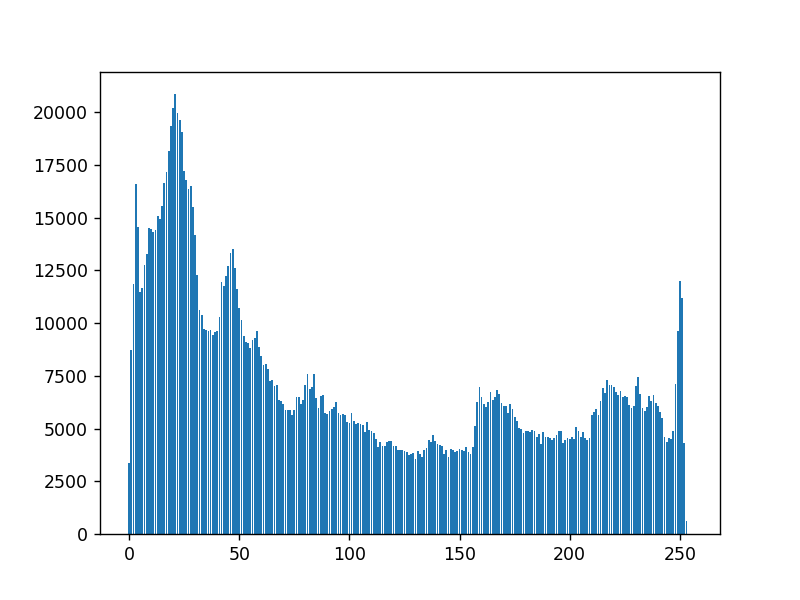

<IPython.core.display.Javascript object>


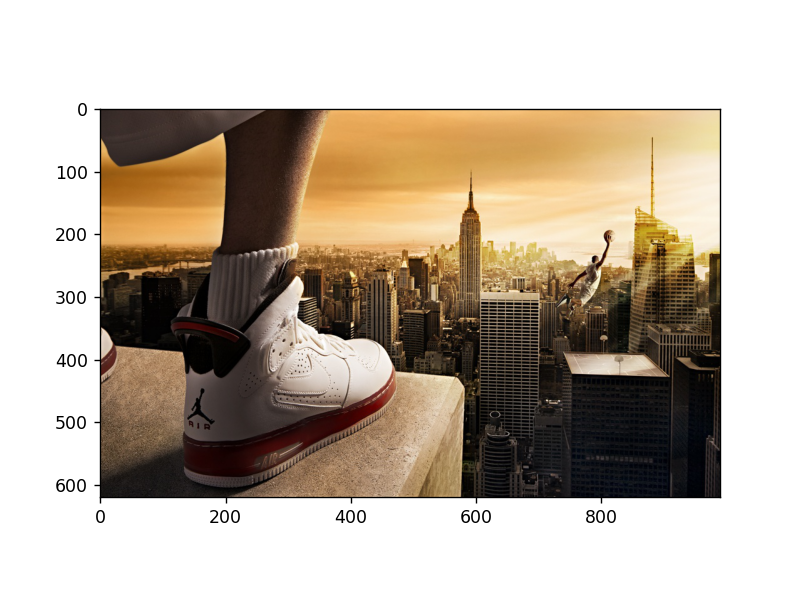

<IPython.core.display.Javascript object>


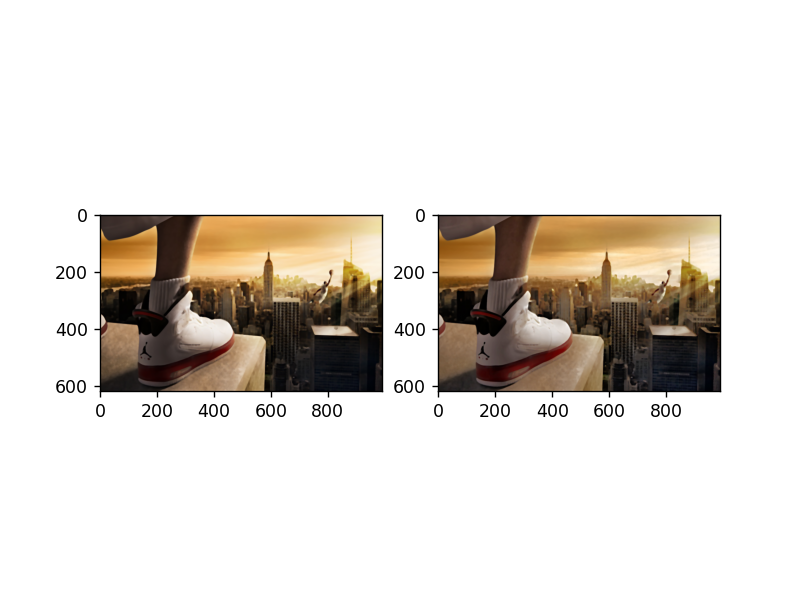

<IPython.core.display.Javascript object>


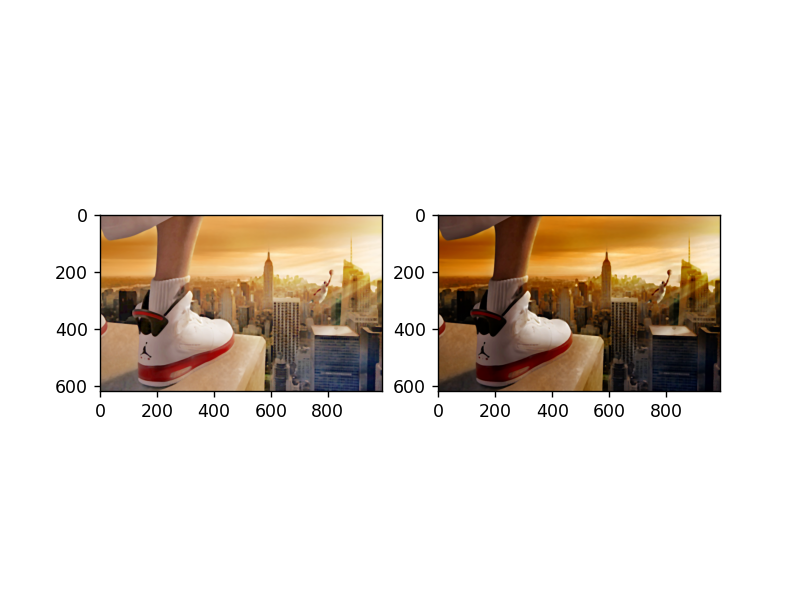

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [457]:
ima = imread('Basketball.jpg')
# Denoising
denoise1 = denoise(ima)
h = [(denoise1 == v).sum() for v in range(256)]   # Histogram of the denoised image
plt.figure()
plt.bar(range(256), h)

# By checking the histogram, I choose Tmin = 0 (because we do have black pixels) and Tmax = 252 approximately
auto = autolevel(denoise1, mode ='yes', TminChosen = 0, TmaxChosen = 252)

# Equalization
equalization = equalize(auto)

# Gamma correction
gamma = 0.5
gam = gamma_corr(equalization, gamma) 

# Increasing the saturation
factor = 1.5
sat = saturation(equalization, factor)

# Display
plt.figure()
plt.imshow(ima)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(denoise1)
plt.subplot(1,2,2)
plt.imshow(equalization.astype('float'))
plt.figure()
plt.subplot(1,2,1)
plt.imshow(gam.astype('float'))
plt.subplot(1,2,2)
plt.imshow(sat)
plt.show()

## Second application

It is an example of denoising using Fourier low pass filter and edge detection if the user wishes. Two ways of edge detection are displayed below. The first one is through the Sobel filter and the second one is through the Fourier high pass filter.

<IPython.core.display.Javascript object>


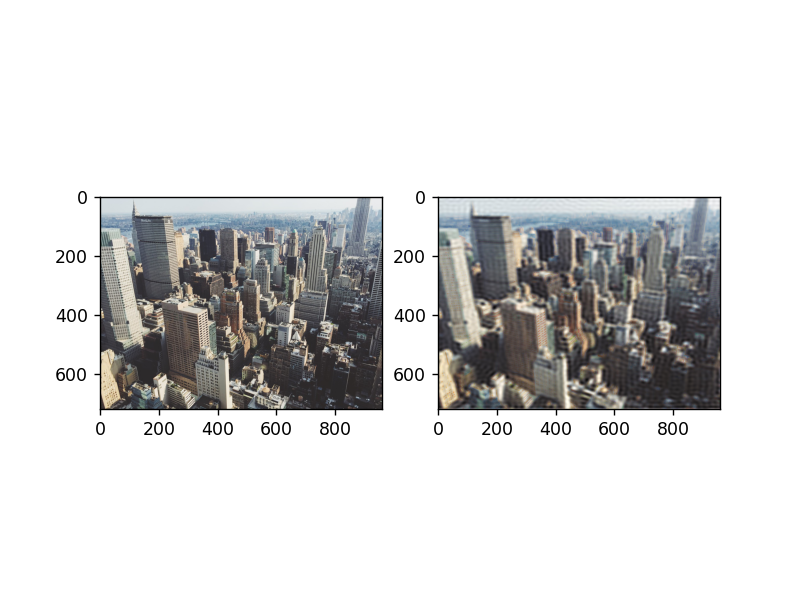

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<IPython.core.display.Javascript object>


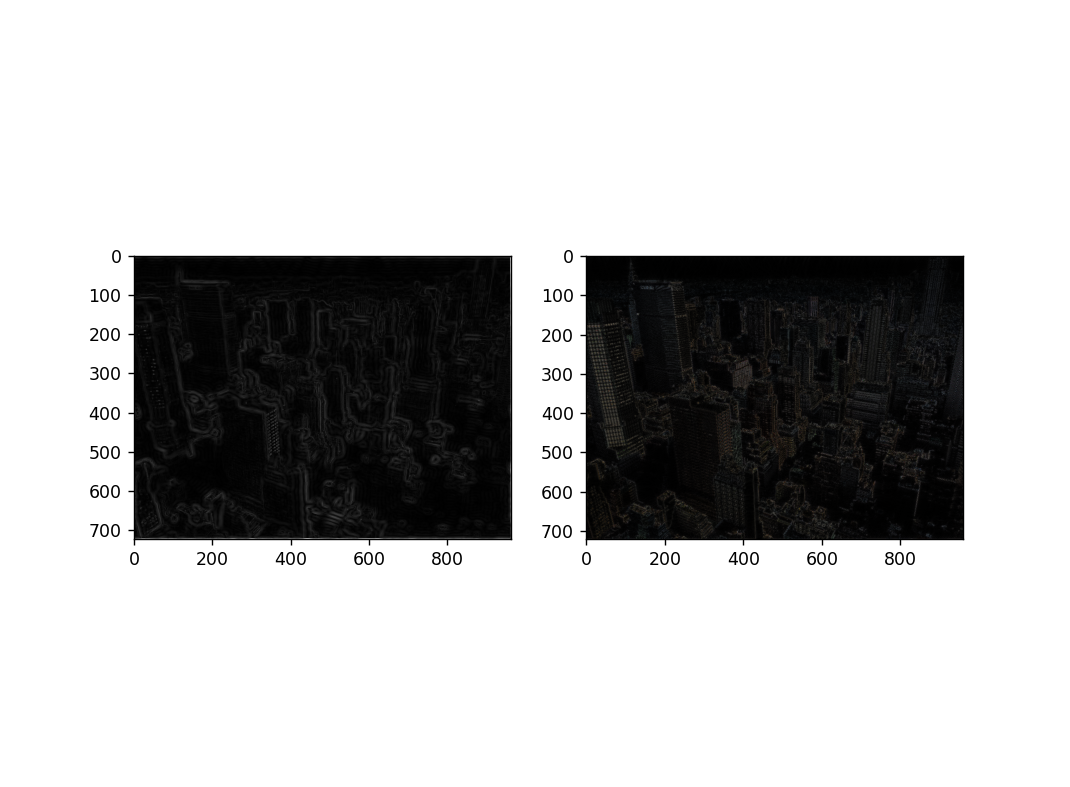

In [452]:
ima = imread('nyc.jpg')

# Denoise using Fourier low pass filter
denoise1 = denoise(ima, 'fourier', radius = 50)

# Edge detection 
edges = edge(denoise1)
edges2 = edge(ima, mode = 'fourier', radius = 180)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(ima)
plt.subplot(1,2,2)
plt.imshow(denoise1)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(edges, cmap = plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(np.abs(edges2), cmap = plt.cm.gray)
plt.show()